In [2]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
DATA = '../../data/'

In [3]:
# Load the data
descriptors = loading.get_descriptors(format='True')
sets = ['training','leaderboard']
all_CIDs = []
for set_ in sets:
    all_CIDs += loading.get_CIDs(set_)
all_CIDs = sorted(all_CIDs)
mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian',],all_CIDs)
mdx_onlydragon = dream.get_molecular_data(['dragon',],all_CIDs)

Dragon has 4869 features for 407 molecules.
Episuite has 62 features for 407 molecules.
Morgan has 2437 features for 407 molecules.
NSPDK has 5392 features for 407 molecules.
NSPDK Gramian has 2437 features for 407 molecules.
There are now 15197 total features.
Dragon has 4869 features for 407 molecules.
There are now 4869 total features.


In [17]:
# Create the feature and descriptor arrays 
X_forest,good1,good2,means,stds,imputer = dream.make_X(mdx,sets)
X_forest_onlydragon,good1_onlydragon,good2_onlydragon,means_onlydragon,stds_onlydragon,imputer_onlydragon = dream.make_X(mdx_onlydragon,sets)
# -1 removes the CID; -6 removes six NaN-heavy episuite features; +2 adds the dilution information
assert len(good1) == len(mdx[0]) -1 +2 -6
Y_all,imputer = dream.make_Y_obs(sets,target_dilution=None,imputer='mask')

The X matrix now has shape (814x13380) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x3063) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Load or compute the random forest model

In [18]:
# Load or compute the random forest model correlations (obtained from cross-validation)
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
#trans_params = params.get_trans_params(Y_all, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

def compute_importance_ranks(X,Y,n_estimators=50,
                  max_features='auto',
                  max_depth=None,min_samples_leaf=1,
                  random_state=0):
    importances = np.zeros((21,X.shape[1])) # Empty matrix to store feature importances.  
    importance_ranks = np.zeros((21,X.shape[1])) # Empty matrix to store feature importance ranks.  
    for col in range(0,21): # For each descriptor.  
        print(col)
        observed = Y[:,col] # Perceptual data for this descriptor.  
        if col==0:
            est = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,n_jobs=8,random_state=random_state)
        else:
            est = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,oob_score=False,n_jobs=8,random_state=random_state)
        est.fit(X,observed) # Fit the model on the training data.  
        importances[col,:] = est.feature_importances_
        importance_ranks[col,:] = np.argsort(est.feature_importances_)[::-1] # Use feature importances to get ranks.  

    return importances,importance_ranks

if False: 
    importances,importance_ranks = compute_importance_ranks(X_forest[:,:-1],Y_all['mean_std'],n_estimators=50)
    np.save('../../data/importances_forest',importances)
    np.save('../../data/importance_ranks_forest',importance_ranks)
else:
    importances = np.load('../../data/importances_forest.npy')
    importance_ranks = np.load('../../data/importance_ranks_forest.npy')
    
if True: 
    importances_onlydragon,importance_ranks_onlydragon = compute_importance_ranks(X_forest_onlydragon[:,:-1],Y_all['mean_std'],n_estimators=50)
    np.save('../../data/importances_forest_onlydragon',importances_onlydragon)
    np.save('../../data/importance_ranks_forest_onlydragon',importance_ranks_onlydragon)
else:
    importances_onlydragon = np.load('../../data/importances_forest_onlydragon.npy')
    importance_ranks_onlydragon = np.load('../../data/importance_ranks_forest_onlydragon.npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [5]:
nspdk_CIDs = pd.read_csv('%s/derived/nspdk_cid.csv' % DATA, header=None, dtype='int').as_matrix().squeeze()
nspdk_dict = dream.make_nspdk_dict(all_CIDs)
nspdk_feature_numbers = list(nspdk_dict.keys())
x = pd.read_table('%s/DREAM_episuite_descriptors.txt' % DATA,index_col=0).drop('SMILES',1)
x = x.loc[all_CIDs]
x.iloc[:,47] = 1*(x.iloc[:,47]=='YES ')
episuite_names = list(x)
episuite = x.as_matrix()
_,good = dream.purge1_X(episuite)
episuite_names = [e for i,e in enumerate(episuite_names) if i in good]
    
with open('%s/morgan_sim.csv' % DATA) as f:
     x = f.readline()
     morgan_template_CIDs = [int(xi) for xi in x.split(',')[1:]]
    
assert len(morgan_template_CIDs) == len(nspdk_CIDs) == 2437

In [6]:
from utils import loading
headers,_ = loading.load_molecular_data()
dragon_feature_names = headers[1:]
# Replace with nspdkgramian range with nspdk_CIDs
all_feature_names = ['dragon_%s' % s for s in dragon_feature_names] + \
                    ['episuite_%s' % x for x in episuite_names] + \
                    ['morgan_%d' % x for x in morgan_template_CIDs] + \
                    ['nspdk_%s' % s for s in nspdk_feature_numbers] + \
                    ['nspdkgramian_%d' % i for i in range(2437)] + ['conc_absolute','conc_relative']
good_feature_names = [all_feature_names[i] for i in good2]
good_feature_names = good_feature_names[:-1] # Remove relative dilution since we didn't use this for the fit
assert(len(good_feature_names) == importance_ranks.shape[1])

In [7]:
new_ranks = pd.DataFrame(importances.T,index=good_feature_names,columns=descriptors)
old_ranks = pd.read_csv('/Users/rgerkin/Desktop/feature_importances.csv',index_col=0)
old_ranks.columns = descriptors
old_ranks.drop('conc_relative',inplace=True)
#old_ranks.drop([s for s in list(old_ranks.index) if 'episuite_' in s],inplace=True)

new_ranks.drop('conc_absolute',inplace=True)
old_ranks.drop('conc_absolute',inplace=True)

In [8]:
desc = 'Pleasantness'
from IPython.display import display
#pd.set_option('display.precision',2)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
display(new_ranks.sort_values(desc,ascending=False)[[desc]].head(10))
display(old_ranks.sort_values(desc,ascending=False)[[desc]].head(10))

,Pleasantness
nspdkgramian_1249,0.0557
nspdkgramian_764,0.0369
morgan_90978,0.0206
dragon_SssO,0.0184
dragon_P_VSA_MR_8,0.0161
dragon_nHM,0.0116
dragon_RDF015s,0.0103
nspdkgramian_199,0.0101
dragon_P_VSA_i_1,0.0089
dragon_MAXDP,0.0074


,Pleasantness
nspdkgramian_1249,0.0466
dragon_RDF015s,0.0263
dragon_SssO,0.0192
nspdkgramian_764,0.0157
dragon_MAXDP,0.0147
dragon_P_VSA_i_1,0.0130
morgan_90978,0.0101
dragon_P_VSA_MR_8,0.0094
nspdkgramian_390,0.0080
dragon_RDF025s,0.0075


In [9]:
nspdk_CIDs[1249],nspdk_CIDs[764],nspdk_CIDs[390]

(36314, 8767, 62902)

Intensity
	0 -> 0 (dragon_B03[C-S])
	1 -> 2 (dragon_F03[C-S])
	2 -> 3 (dragon_Eig07_AEA(dm))
	3 -> 39 (dragon_Eig08_AEA(dm))
	4 -> 6 (dragon_O-057)
	5 -> 4 (dragon_C-028)
	6 -> 4710 (dragon_H-049)
	7 -> 9 (dragon_Mor30p)
	8 -> 360 (dragon_Eig10_AEA(dm))
	9 -> 41 (dragon_SpAbs_B(s))
Pleasantness
	0 -> 0 (nspdkgramian_1249)
	1 -> 6 (dragon_RDF015s)
	2 -> 3 (dragon_SssO)
	3 -> 1 (nspdkgramian_764)
	4 -> 9 (dragon_MAXDP)
	5 -> 8 (dragon_P_VSA_i_1)
	6 -> 2 (morgan_90978)
	7 -> 4 (dragon_P_VSA_MR_8)
	8 -> 13 (nspdkgramian_390)
	9 -> 55 (dragon_RDF025s)
Bakery
	0 -> 14 (nspdk_253902)
	1 -> 17 (nspdk_1022278)
	2 -> 24 (nspdk_722140)
	3 -> 16 (nspdk_250366)
	4 -> 19 (nspdk_555472)
	5 -> 4 (nspdk_544811)
	6 -> 5 (nspdk_214067)
	7 -> 11756 (nspdk_430273)
	8 -> 9 (nspdk_199698)
	9 -> 23 (nspdk_410940)
Sweet
	0 -> 0 (nspdkgramian_390)
	1 -> 8 (nspdkgramian_199)
	2 -> 10 (morgan_102861)
	3 -> 4 (morgan_8467)
	4 -> 17 (nspdk_939920)
	5 -> 16 (nspdk_338410)
	6 -> 23 (morgan_158410)
	7 -> 77 (nspdk_248

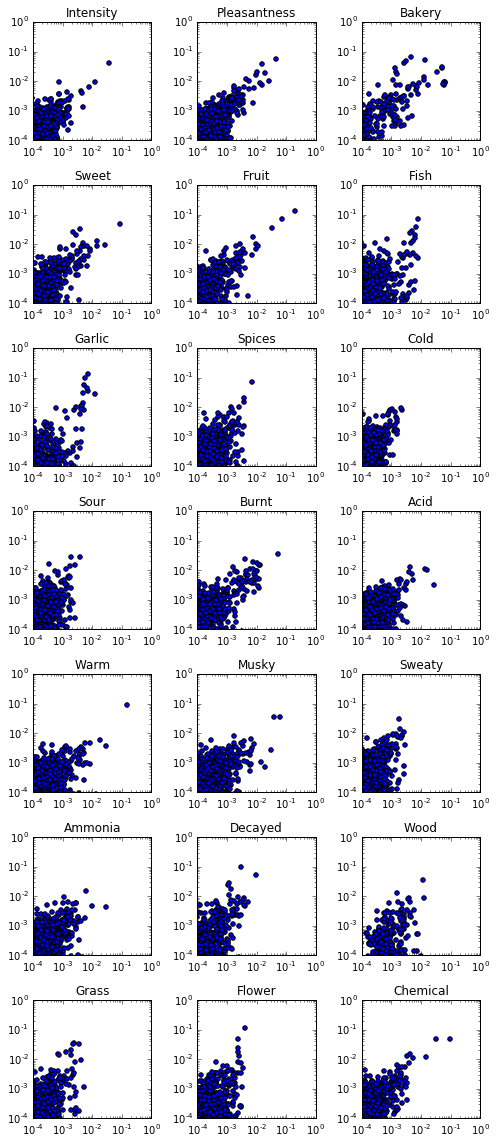

In [10]:
diff = list(set(list(old_ranks.index)).difference(new_ranks.index))
old_ranks_2 = old_ranks.drop(diff,0).loc[new_ranks.index]
fig,axes = plt.subplots(7,3,figsize=(7,16))
for i,desc in enumerate(descriptors):
    old_sorted = list(old_ranks_2.sort_values(desc,ascending=False).index)
    new_sorted = list(new_ranks.sort_values(desc,ascending=False).index)
    print(desc)
    for j in range(10):
        old_name = old_sorted[j]
        print("\t%d -> %d (%s)" % (j,new_sorted.index(old_name),old_name))
    ax = axes.flat[i]
    #print(desc)
    old = old_ranks_2[desc]
    new = new_ranks[desc]
    ax.scatter(old,new)
    ax.set_xlim(0.0001,1)
    ax.set_ylim(0.0001,1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(desc)
plt.tight_layout()

In [11]:
for i,desc in enumerate(descriptors):
    new_sorted = list(new_ranks.sort_values(desc,ascending=False).index)
    print(desc)
    for j in range(5):
        new_name = new_sorted[j]
        if 'nspdkgramian_' in new_name:
            _,index = new_name.split('_')
            cid = nspdk_CIDs[int(index)]
            new_name = 'nspdkgramian_%d' % cid
        print("\t%d) %s" % (j+1,new_name))

Intensity
	1) dragon_B03[C-S]
	2) dragon_LLS_01
	3) dragon_F03[C-S]
	4) dragon_Eig07_AEA(dm)
	5) dragon_C-028
Pleasantness
	1) nspdkgramian_36314
	2) nspdkgramian_8767
	3) morgan_90978
	4) dragon_SssO
	5) dragon_P_VSA_MR_8
Bakery
	1) nspdkgramian_539829
	2) morgan_12127
	3) nspdkgramian_8655
	4) nspdkgramian_1183
	5) nspdk_544811
Sweet
	1) nspdkgramian_62902
	2) dragon_SssO
	3) nspdkgramian_8655
	4) morgan_12127
	5) morgan_8467
Fruit
	1) nspdkgramian_62902
	2) morgan_102861
	3) nspdk_338410
	4) nspdkgramian_5367682
	5) nspdk_993867
Fish
	1) dragon_P_VSA_m_4
	2) nspdkgramian_522181
	3) dragon_X4Av
	4) dragon_P_VSA_i_1
	5) dragon_NssS
Garlic
	1) dragon_HATS3p
	2) nspdkgramian_9264
	3) dragon_P_VSA_m_4
	4) nspdkgramian_15380
	5) nspdk_264584
Spices
	1) nspdkgramian_68252
	2) nspdkgramian_9264
	3) morgan_7461
	4) morgan_80790
	5) morgan_84398
Cold
	1) morgan_94174
	2) dragon_R5i
	3) dragon_TPSA(Tot)
	4) morgan_8748
	5) dragon_H0m
Sour
	1) morgan_264
	2) dragon_Mor13m
	3) nspdkgramian_36025

In [15]:
for i,desc in enumerate(descriptors):
    old_sorted = list(old_ranks.sort_values(desc,ascending=False).index)
    print(desc)
    for j in range(20):
        old_name = old_sorted[j]
        if 'nspdkgramian_' in old_name:
            _,index = old_name.split('_')
            cid = nspdk_CIDs[int(index)]
            new_name = 'nspdkgramian_%d' % cid
        else:
            new_name = old_name
        print("\t%d) %s" % (j+1,new_name))

Intensity
	1) dragon_B03[C-S]
	2) dragon_F03[C-S]
	3) dragon_Eig07_AEA(dm)
	4) dragon_Eig08_AEA(dm)
	5) dragon_O-057
	6) dragon_C-028
	7) dragon_H-049
	8) dragon_Mor30p
	9) dragon_Eig10_AEA(dm)
	10) dragon_SpAbs_B(s)
	11) dragon_DLS_01
	12) dragon_C-008
	13) dragon_Psi_i_s
	14) dragon_MATS7e
	15) morgan_16997
	16) nspdk_102816
	17) dragon_ATS2s
	18) dragon_Eig04_AEA(dm)
	19) dragon_ATS1s
	20) dragon_Ho_B(s)
Pleasantness
	1) nspdkgramian_36314
	2) dragon_RDF015s
	3) dragon_SssO
	4) nspdkgramian_8767
	5) dragon_MAXDP
	6) dragon_P_VSA_i_1
	7) morgan_90978
	8) dragon_P_VSA_MR_8
	9) nspdkgramian_62902
	10) dragon_RDF025s
	11) dragon_CATS2D_04_AL
	12) dragon_SpPosA_B(m)
	13) nspdkgramian_8467
	14) dragon_nHM
	15) dragon_Mor05s
	16) dragon_H0p
	17) dragon_R2s+
	18) morgan_6988
	19) nspdkgramian_1118
	20) morgan_8467
Bakery
	1) nspdk_253902
	2) nspdk_1022278
	3) nspdk_722140
	4) nspdk_250366
	5) nspdk_555472
	6) nspdk_544811
	7) nspdk_214067
	8) nspdk_430273
	9) nspdk_199698
	10) nspdk_410940


In [22]:
from utils import loading
headers,_ = loading.load_molecular_data()
dragon_feature_names = headers[1:]
all_feature_names_onlydragon = ['dragon_%s' % s for s in dragon_feature_names] + ['conc_absolute','conc_relative']
good_feature_names_onlydragon = [all_feature_names_onlydragon[i] for i in good2_onlydragon]
good_feature_names_onlydragon = good_feature_names_onlydragon[:-1] # Remove relative dilution since we didn't use this for the fit
assert(len(good_feature_names_onlydragon) == importance_ranks_onlydragon.shape[1])
new_ranks_onlydragon = pd.DataFrame(importances_onlydragon.T,index=good_feature_names_onlydragon,columns=descriptors)
new_ranks_onlydragon.drop('conc_absolute',inplace=True)

for i,desc in enumerate(descriptors):
    new_sorted_onlydragon = list(new_ranks_onlydragon.sort_values(desc,ascending=False).index)
    print(desc)
    for j in range(20):
        name = new_sorted_onlydragon[j]
        print("\t%d) %s" % (j+1,name))

Intensity
	1) dragon_B03[C-S]
	2) dragon_F03[C-S]
	3) dragon_Eig07_AEA(dm)
	4) dragon_C-028
	5) dragon_O-057
	6) dragon_Mor30p
	7) dragon_MATS7e
	8) dragon_ATSC2p
	9) dragon_NssS
	10) dragon_Wi_B(s)
	11) dragon_Eig08_AEA(dm)
	12) dragon_Psi_i_s
	13) dragon_DLS_01
	14) dragon_LLS_01
	15) dragon_MATS7m
	16) dragon_DISPe
	17) dragon_SpMax3_Bh(s)
	18) dragon_Eig06_EA
	19) dragon_WiA_B(p)
	20) dragon_MATS7s
Pleasantness
	1) dragon_SssO
	2) dragon_RDF015s
	3) dragon_P_VSA_MR_8
	4) dragon_MAXDP
	5) dragon_nHM
	6) dragon_P_VSA_i_1
	7) dragon_Mor17s
	8) dragon_Mor05s
	9) dragon_R2s+
	10) dragon_GATS2e
	11) dragon_P_VSA_m_4
	12) dragon_Mor30s
	13) dragon_CATS2D_04_AL
	14) dragon_RDF025s
	15) dragon_P_VSA_LogP_5
	16) dragon_GATS2s
	17) dragon_R6m+
	18) dragon_Mor02p
	19) dragon_R7s+
	20) dragon_RDF025p
Bakery
	1) dragon_Mor17s
	2) dragon_R7e+
	3) dragon_Mor12s
	4) dragon_SHP2
	5) dragon_Eig12_AEA(ri)
	6) dragon_CIC2
	7) dragon_C-037
	8) dragon_MATS6i
	9) dragon_MATS3s
	10) dragon_R6i+
	11) dragon

In [4]:
nspdk_dict = dream.make_nspdk_dict(all_CIDs)

In [9]:
x = 0
for key,value in list(nspdk_dict.items()):
    x += len(value)
x /= len(nspdk_dict)
x

7.506491097922849

In [8]:
len(nspdk_dict)

5392